# Example 3
In this example, we detect core-periphery structure in the political blog network. 

# Packages

In [2]:
%load_ext autoreload
%autoreload 2
import sys

sys.path.insert(0, "/Users/skojaku-admin/program/core-periphery-detection")
import cpnet

import matplotlib.pyplot as plt
import seaborn as sns

import networkx as nx
import numpy as np
import pandas as pd
import matplotlib as mpl

# import utils
from scipy import sparse

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Data

The worldwide airport network constructed from the openflight data.

Data source: 
- http://konect.cc/networks/dimacs10-polblogs/
- https://www.cc.gatech.edu/dimacs10/archive/clustering.shtml

In [4]:
# Load the blog net
edges = pd.read_csv(
    "https://raw.githubusercontent.com/skojaku/core-periphery-detection/add-notebook/data/out.moreno_blogs_blogs?token=AEJQ7B2R37SGEAUYDQBRALK7O2JYW"
)
node_table = pd.read_csv(
    "https://raw.githubusercontent.com/skojaku/core-periphery-detection/add-notebook/data/ent.moreno_blogs_blogs.blog.orientation?token=AEJQ7B6BERYDDW3THRAZFEK7O2J3G",
    sep=",",
    header=None,
    names=["class"],
)
N = np.max(edges.max().values) + 1
net = sparse.csc_matrix(
    (np.ones(edges.shape[0]), (edges.source - 1, edges.target - 1)), shape=(N, N)
)

# Extract the largest connected component
G = nx.from_scipy_sparse_matrix(net)
node_set = sorted(nx.connected_components(G), key=len, reverse=True)[0]
G = G.subgraph(node_set)
node_table = node_table.iloc[np.array(list(node_set)), :]

# Convert to the adjacency matrix
net = nx.adjacency_matrix(G)
net = net + net.T
net.data = np.ones_like(net.data)

node_table["id"] = np.arange(net.shape[0])

In [6]:
print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 1222
Number of edges: 16717
Average degree:  27.3601


# Detect core-periphery structure

In [7]:
# Detect core-periphery structure
kmconfig = cpnet.KM_config()  # Call the BE algorithm
kmconfig.detect(G)  # Detect core-periphery structures
c = kmconfig.get_pair_id()  # Get the group membership of nodes
x = kmconfig.get_coreness()  # Get the coreness of nodes

# Statistical test

In [8]:
sig_c, sig_x, significant, p_values = cpnet.qstest(
    c, x, G, kmconfig, significance_level=0.05, num_of_rand_net=100, num_of_thread=4
)

100%|██████████| 100/100 [00:34<00:00,  2.92it/s]


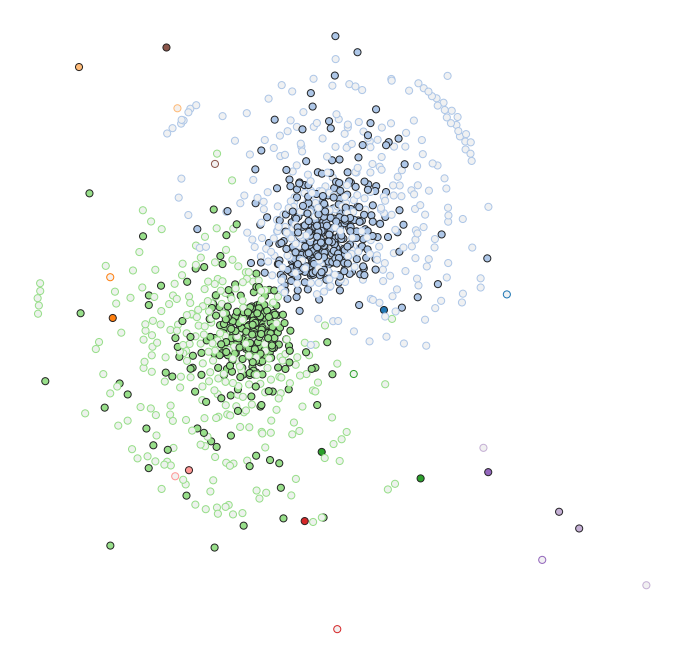

In [10]:
# Visualization
fig = plt.figure(figsize=(12, 12))
ax = plt.gca()

draw_nodes_kwd = {"node_size": 50, "linewidths": 1}
ax, pos = cpnet.utils.draw(G, c, x, ax, draw_nodes_kwd=draw_nodes_kwd, draw_edge=False)

# Interactive plot

Please make sure that your jupyter lab or notebook has an extention for plotly. See [the instruction](https://plotly.com/python/getting-started/) to install the extention.

With conda, run

```bash
conda install nodejs
conda install jupyterlab "ipywidgets=7.5"
jupyter labextension install jupyterlab-plotly@4.10.0
jupyter labextension install @jupyter-widgets/jupyterlab-manager plotlywidget@4.10.0
```

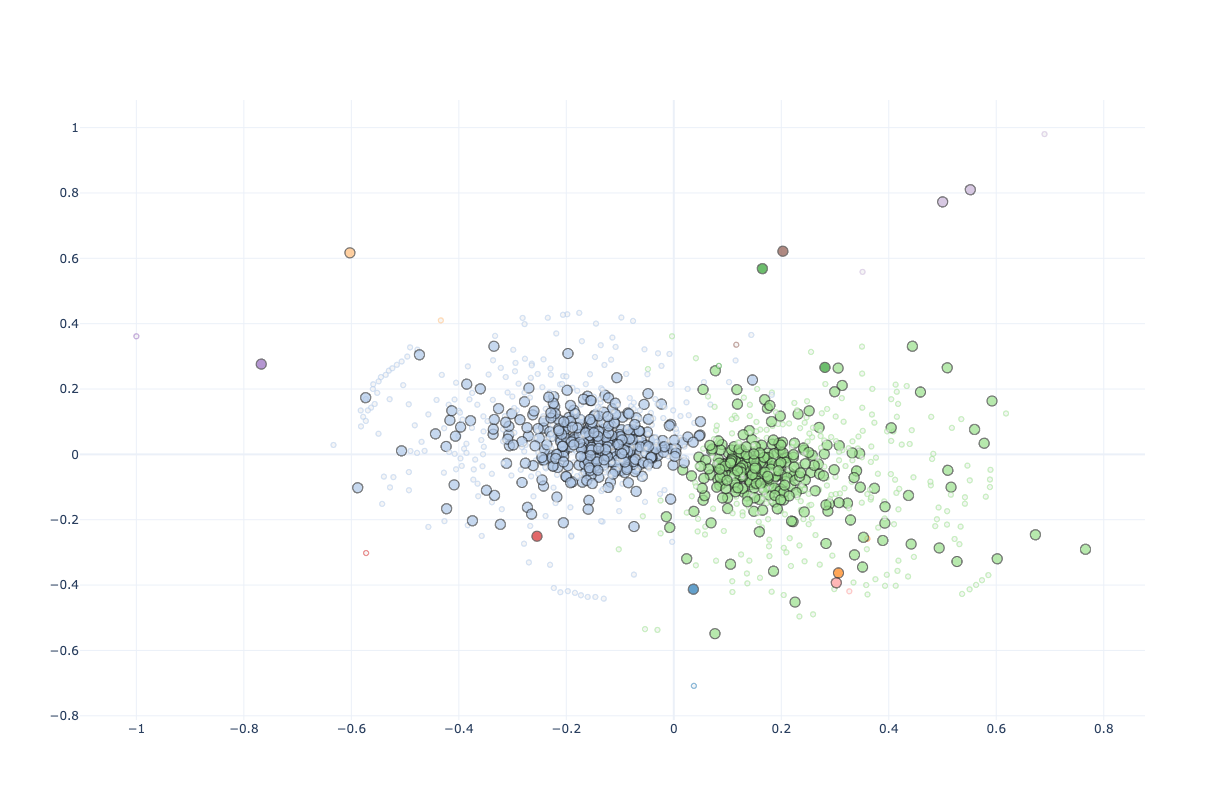

In [14]:
dhover_text = {
    row["id"]: "Leaning: {class}".format(**row) for i, row in node_table.iterrows()
}
fig = cpnet.utils.draw_interactive(G, c, x, hover_text=hover_text, node_size=5)
fig.show()